# 📊 Statistical Arbitrage: BTC vs ETH

This notebook implements a basic pair trading (mean-reversion) strategy using Binance data for BTC/USDT and ETH/USDT.

This approach assumes:
- The spread between BTC and ETH (e.g., BTC − β·ETH) is assumed to revert to a long-term equilibrium.
- Hedge ratio β varies slowly.
- The residuals (spread) are assumed to be normally distributed around a mean.

## 🔧 Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import statsmodels.api as sm

## 📥 Fetch Historical Data from Binance
We will use the 6h frequency for a balance between signal granularity and execution practicality. 
We are downloading 9 months amount of BTC and ETH data.

In [2]:
from binance.client import Client
import pandas as pd
import time

client = Client(api_key='', api_secret='', tld='us')

def get_binance_data(symbol, interval, start_str, end_str=None):
    df = pd.DataFrame(client.get_historical_klines(symbol, interval, start_str, end_str))
    df = df.iloc[:, :6]
    df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df = df.astype(float)
    return df

# Pull 30 days of 5-min BTC/ETH data
btc = get_binance_data("BTCUSDT", "6h", "1 June, 2024", "1 March, 2025")
eth = get_binance_data("ETHUSDT", "6h", "1 June, 2024", "1 March, 2025")

## 📊 Plot Price Series

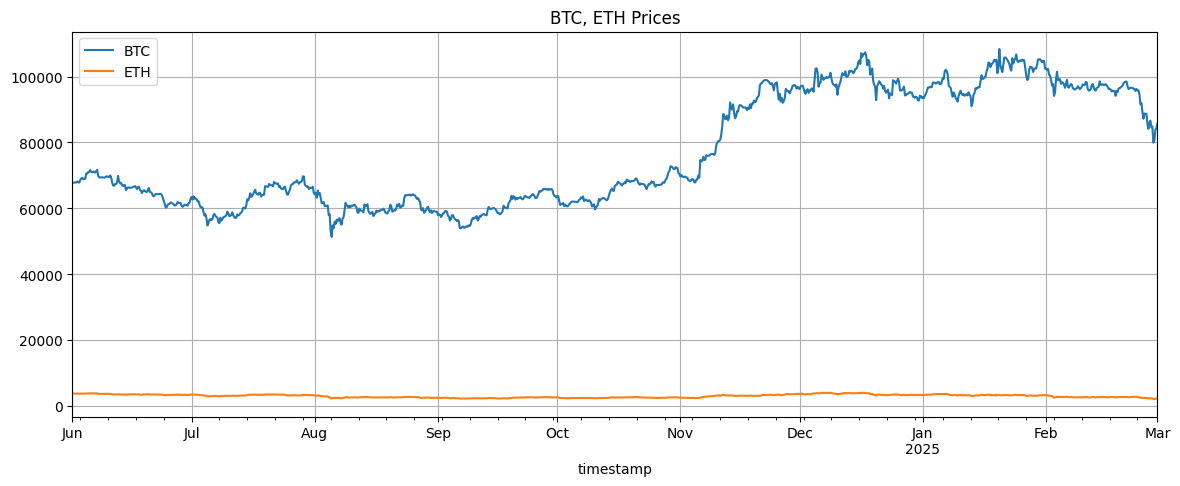

In [3]:
btc['close'].plot(label='BTC', figsize=(14,5))
eth['close'].plot(label='ETH')
plt.title('BTC, ETH Prices')
plt.legend()
plt.grid(True)
plt.show()

## 🔍 Construct Price Spread and Z-score

Let's calcualte rolling β and spread(BTC − β·ETH) with a given time window.

In [4]:
window = 40  # rolling window in timesteps (e.g., 40*6h ~ 10 days)
betas = []
spreads = []

btc_prices = btc['close']
eth_prices = eth['close']

for i in range(window, len(btc_prices)):
    y = btc_prices.iloc[i - window:i]
    X = eth_prices.iloc[i - window:i]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params.iloc[1]
    betas.append(beta)

    # Use this beta to calculate current spread
    spread = btc_prices.iloc[i] - beta * eth_prices.iloc[i]
    spreads.append(spread)

# Convert to aligned pandas Series
index = btc_prices.index[window:]
spread_series = pd.Series(spreads, index=index)
beta_series = pd.Series(betas, index=index)

In [ ]:
spread_mean = spread_series.rolling(50).mean() # rolling window: 12.5 days
spread_std = spread_series.rolling(50).std()
zscore = (spread_series - spread_mean) / spread_std

## 📈 Plot Z-score and Thresholds

- The spread values are assumed to be normally distributed around a mean.

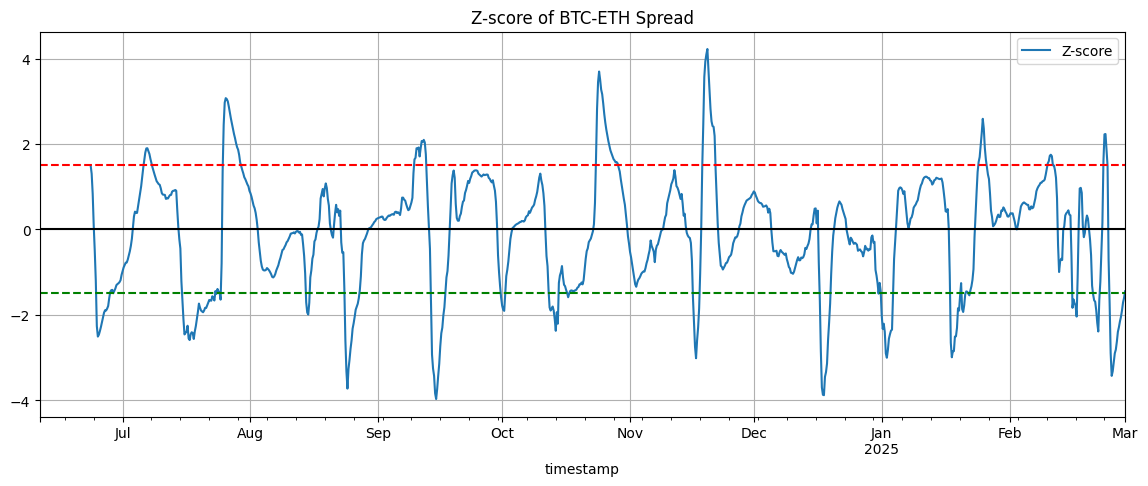

In [7]:
plt.figure(figsize=(14,5))
zscore.plot(label='Z-score')
plt.axhline(1.5, color='r', linestyle='--')
plt.axhline(-1.5, color='g', linestyle='--')
plt.axhline(0, color='k', linestyle='-')
plt.title('Z-score of BTC-ETH Spread')
plt.legend()
plt.grid(True)
plt.show()

## 🧠 Generate Trading Signals (Mean Reversion Logic)

- The signals are long/short/exit using the Z-score range.
- Long on one unit of BTC (short on one unit of ETH) if the Z-score < -1.5,
- Short on one unit of BTC (long on one unit of BTC) if the Z-score > 1.5, 
- exit if |Z-score| < 0.5 



In [8]:
signals = pd.DataFrame(index=zscore.index)
signals['zscore'] = zscore
signals['long'] = zscore < -1.5
signals['short'] = zscore > 1.5
signals['exit'] = (zscore.abs() < 0.5)

signals[['long', 'short', 'exit']] = signals[['long', 'short', 'exit']].astype(int)
signals.tail(5)

,zscore,long,short,exit
timestamp,,,,
2025-02-28 00:00:00,-2.045216,1,0,0
2025-02-28 06:00:00,-1.896639,1,0,0
2025-02-28 12:00:00,-1.711174,1,0,0
2025-02-28 18:00:00,-1.602474,1,0,0
2025-03-01 00:00:00,-1.448568,0,0,0


## 📉 Backtest (Simplified PnL Approximation)

In [9]:
fees = 0.0005  # 5 basis points per trade
btc_price = btc['close'].loc[signals.index]
eth_price = eth['close'].loc[signals.index]

#capital = 100_000  # Starting capital in dollars

In [10]:
positions = []
btc_positions = []
eth_positions = []
pnl = []
position = 0  # 1 = long spread, -1 = short spread, 0 = flat
prev_position = 0
fee_cumulative = 0

for t in range(1, len(signals)):
    # Entry logic
    if position == 0:
        if signals['long'].iloc[t - 1]:
            position = 1
        elif signals['short'].iloc[t - 1]:
            position = -1

    # Exit logic
    elif signals['exit'].iloc[t - 1]:
        position = 0

    # Fee incurred on position change
    if position != prev_position:
        # Round-trip fee based on price
        fee = fees * (btc_price.iloc[t] + beta_series.iloc[t]*eth_price.iloc[t])
        fee_cumulative += fee
    else:
        fee = 0

    # Spread return
    spread_ret = spread_series.iloc[t] - spread_series.iloc[t - 1]
    #pnl.append(position * spread_ret - fee)
    raw_pnl = position * spread_ret - fee
    #normalized_return = raw_pnl / capital
    pnl.append(raw_pnl)
    #pnl.append(normalized_return)
    positions.append(position)
    prev_position = position

    # Track BTC/ETH legs
    if position == 1:  # Long spread
        btc_positions.append(1)
        eth_positions.append(-1)
    elif position == -1:  # Short spread
        btc_positions.append(-1)
        eth_positions.append(1)
    else:
        btc_positions.append(0)
        eth_positions.append(0)

In [11]:
signals = signals.iloc[1:]  # align indexing after loop

In [12]:
# Assign backtest results to DataFrame

signals['position'] = positions
signals['btc_leg'] = btc_positions
signals['eth_leg'] = eth_positions
signals['pnl'] = pnl
signals['cum_pnl'] = np.cumsum(pnl)
signals['cumulative_return'] = (1 + pd.Series(pnl, index=signals.index)).cumprod()


/Users/jwayeonjae/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


In [13]:
signals['position_change'] = signals['position'].diff().fillna(0).abs() > 0

In [14]:

# Compute Sharpe and drawdown
returns = pd.Series(pnl)
sharpe = returns.mean() / returns.std() * np.sqrt(365 * 4)  # annualized

cum_pnl = signals['cum_pnl']
rolling_max = cum_pnl.cummax()
drawdown = rolling_max - cum_pnl
max_dd = drawdown.max()

print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_dd:.2f}")
print(f"Total Fees Incurred: {fee_cumulative:.2f}")


Sharpe Ratio: 1.60
Max Drawdown: 114025.42
Total Fees Incurred: 2598.24


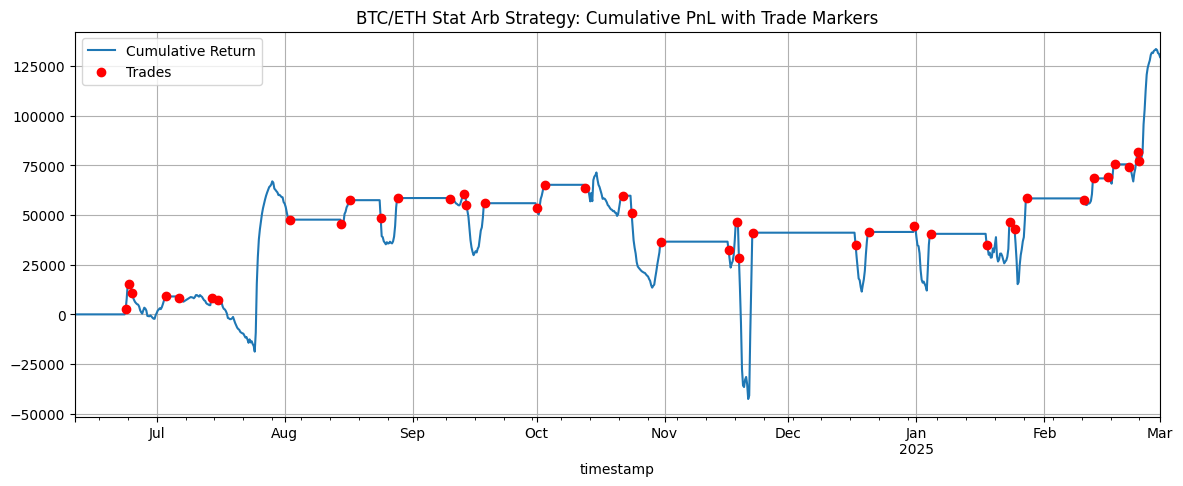

In [ ]:
plt.figure(figsize=(14,5))
signals['cum_pnl'].plot(label='Cumulative Return')
plt.scatter(signals[signals['position_change']].index, signals['cum_pnl'][signals['position_change']], color='red', marker='o', label='Trades', zorder=5)
plt.title("BTC/ETH Stat Arb Strategy: Cumulative PnL with Trade Markers")
plt.legend()
plt.grid(True)

plt.show()


## 🧾 Final Remarks and Conclusion

This notebook implemented and backtested a market-neutral statistical arbitrage strategy between BTC and ETH based on dynamic hedge ratio estimation and mean-reversion in the spread.

### ✅ Key Elements:
- A **rolling OLS** model was used to estimate the dynamic hedge ratio (β), constructing the spread as - (BTC − β·ETH).
- **Z-score bands** were applied to detect deviations from the mean spread and generate long/short entry signals.
- Position exit occurred when the spread reverted close to its mean (|z| < 0.5), capturing the mean-reversion cycle.
- The strategy was backtested with a simple fee model.
- Performance metrics such as Sharpe ratio, cumulative fee, and cumulative return were used to evaluate results.

### ⚠️ Limitations:
- The hedge ratio may be unstable with short rolling windows.
- The spread's stationarity should be tested and may vary by regime.
- No slippage or order book dynamics were modeled; all execution was assumed perfect.
- Crypto markets are subject to structural breaks — longer backtests may include periods with very different dynamics.

### 🧠 Suggestions for Improvement:
- Backtest over multiple rolling windows and trading pairs.
- Explore execution with **limit orders**, order book simulation, or live trading environments.

---

This notebook serves as a working prototype for developing market-neutral crypto trading strategies and can be extended into a full backtesting and live execution pipeline.
